# PROJECT: Positive and Negative Sentiment Analysis Using Transformer

This project aims to perform sentiment analysis of Bengali texts. The [dataset](https://data.mendeley.com/datasets/p6zc7krs37/4) used in this analysis consists of positive and negative reviews collected from Youtube Bengali drama $^{1}$. 

The model is formulated as a binary classification problem using attention network and CrossEntropyLoss function. The model structure is coded with the help of [Attention from scratch](https://medium.com/the-dl/transformers-from-scratch-in-pytorch-8777e346ca51)$^{2}$. In order to avoid the imbalance of the dataset, equal number of positive and negative reviews are taken as the training set. The model is trained on 1084 sentences, which comprise 80\% of the dataset of sentences each containing 20 words or less. 

Approximately 86\% of the test set of 138 samples is correctly classified by the trained model. It took around 50 epochs to reach this accuracy level. It is possible that better generalization ability of the model can be achieved with larger training set with higher variance. It is important to note here that the model's performance significantly depends on the nature of the training set as in some of the trial runs with a different training set (generated by random shuffle and choice) the model failed to produce any meaningful predictions. Both early stopping and learning rate scheduler are implemented to track the overfitting of the model.

In [1]:
import numpy as np
import re
import random
import multiprocessing as mp

import matplotlib.pyplot as plt

import torch
from collections import OrderedDict

In [2]:
def positional_encoding(seq_len, n_feature):
    pos = torch.arange(seq_len, dtype = torch.float).reshape(1, -1, 1)
    dim = torch.arange(n_feature, dtype = torch.float).reshape(1, 1, -1)
    phase = pos / (1e4 ** torch.div(dim, n_feature, rounding_mode = 'trunc'))
    pos_enc_out = torch.where(dim.long() % 2 == 0, torch.sin(phase), torch.cos(phase))
    return pos_enc_out

class AttentionHead(torch.nn.Module):
    def __init__(self, n_embed, n_qkv):
        super().__init__()
        self.query = torch.nn.Linear(n_embed, n_qkv)
        self.key = torch.nn.Linear(n_embed, n_qkv)
        self.value = torch.nn.Linear(n_embed, n_qkv)
        
    def forward(self, query, key, value):
        q = self.query(query)
        k = self.key(key)
        v = self.value(value)
        
        # scaled dot product
        
        attention = q.bmm(k.transpose(1, 2))
        scale = q.size(-1)**0.5
        scaled_attn = attention / scale
        soft_scaled_attn = torch.nn.functional.softmax(scaled_attn, dim = -1)
        attn_out = soft_scaled_attn.bmm(v)
        
        return attn_out
    
class MultiHeadAttention(torch.nn.Module):
    def __init__(self, n_embed, n_qkv, n_head):
        super().__init__()
        self.attention_heads = torch.nn.ModuleList([AttentionHead(n_embed, n_qkv) for _ in range(n_head)])
        self.linear = torch.nn.Linear(n_qkv * n_head, n_embed)
        
    def forward(self, query, key, value):
        attn_heads_out = torch.cat([attn_h(query, key, value) for attn_h in self.attention_heads], dim = -1)
        return self.linear(attn_heads_out)
    
class FeedForward(torch.nn.Module):
    def __init__(self, n_embed, n_ffn):
        super().__init__()
        self.linear_1 = torch.nn.Linear(n_embed, n_ffn)
        self.activation = torch.nn.ReLU()
        self.linear_2 = torch.nn.Linear(n_ffn, n_embed)
        
    def forward(self, X):
        
        # No special operation; therefore, can be replaced by torch sequential
        
        ffn_out = self.linear_2(self.activation(self.linear_1(X)))
        return ffn_out
    
class ResidualBlock(torch.nn.Module):
    def __init__(self, sublayer, dim_sublayer, dropout):
        super().__init__()
        self.sublayer = sublayer
        self.norm_layer = torch.nn.LayerNorm(dim_sublayer)
        self.dropout_layer = torch.nn.Dropout(dropout)
        
    def forward(self, *inputs):
        out_sublayer = self.sublayer(*inputs)
        out_residual = self.norm_layer(inputs[0] + self.dropout_layer(out_sublayer))
        return out_residual
    
class EncoderLayer(torch.nn.Module):
    def __init__(self, n_embed, n_qkv, n_head, n_ffn, dropout):
        super().__init__()
        self.multi_head_attention = ResidualBlock(MultiHeadAttention(n_embed, n_qkv, n_head), n_embed, dropout)
        self.feed_forward = ResidualBlock(FeedForward(n_embed, n_ffn), n_embed, dropout)
        
    def forward(self, source):
        mh_attn_out = self.multi_head_attention(source, source, source)
        return self.feed_forward(mh_attn_out)
    
class EncoderBlock(torch.nn.Module):
    def __init__(self, n_layers, n_embed, n_qkv, n_head, n_ffn, dropout):
        super().__init__()
        self.encoder_layers = torch.nn.ModuleList([EncoderLayer(n_embed, n_qkv, n_head, n_ffn, dropout) 
                                                   for _ in range(n_layers)])
        
    def forward(self, source):
        # add positional encoding
        source += positional_encoding(source.shape[1], source.shape[2])
        
        for layer in self.encoder_layers:
            source = layer(source)
        
        return source
    
class DecoderLayer(torch.nn.Module):
    def __init__(self, n_embed, n_qkv, n_head, n_ffn, dropout):
        super().__init__()
        self.multi_head_attention_1 = ResidualBlock(MultiHeadAttention(n_embed, n_qkv, n_head), n_embed, dropout)
        self.multi_head_attention_2 = ResidualBlock(MultiHeadAttention(n_embed, n_qkv, n_head), n_embed, dropout)
        self.feed_forward = ResidualBlock(FeedForward(n_embed, n_ffn), n_embed, dropout)
        
    def forward(self, target, memory):
        mh_attn_out_1 = self.multi_head_attention_1(target, target, target)
        mh_attn_out_2 = self.multi_head_attention_2(mh_attn_out_1, memory, memory)
        ffn_out = self.feed_forward(mh_attn_out_2)
        
        return ffn_out
    
class DecoderBlock(torch.nn.Module):
    def __init__(self, n_layers, n_embed, n_qkv, n_head, n_ffn, dropout):
        super().__init__()
        self.decoder_layers = torch.nn.ModuleList([DecoderLayer(n_embed, n_qkv, n_head, n_ffn, dropout) for _ in range(n_layers)])
        self.linear_out = torch.nn.Linear(n_ffn, n_out)
        
    def forward(self, target, memory):
        target += positional_encoding(target.size[1], target.size[2])
        for layer in self.decoder_layers:
            target = layer(target, memory)
        #output = self.linear_out(target)
        
        return target #torch.softmax(output)
    
class Transformer(torch.nn.Module):
    def __init__(self, n_layers, n_embed, n_qkv, n_head, n_ffn, dropout):
        super().__init__()
        self.encoder = EncoderBlock(n_layers, n_embed, n_qkv, n_head, n_ffn, dropout)
        self.decoder = DecoderBlock(n_layers, n_embed, n_qkv, n_head, n_ffn, dropout)
        
    def forward(self, source, target=None):
        n_samples = source.shape[0]
        memory = self.encoder(source)
        if target is None:
            return memory.reshape(n_samples, -1)
        dec_out = self.decoder(target, memory)
        return dec_out
    


In [3]:
# Create sentiment classification Transformer model.  

class SentimentAnalysis():
    def __init__(self, seq_len, vocab_size, n_embed, n_out, n_layers, n_qkv, n_head, n_ffn, dropout):
        
        self.embedding = torch.nn.Embedding(vocab_size+1, n_embed, padding_idx = 0)
        self.transformer_block = Transformer(n_layers, n_embed, n_qkv, n_head, n_ffn, dropout)
        self.output_layer = torch.nn.Linear(n_embed * seq_len, n_out)
        self.neunet = torch.nn.Sequential(OrderedDict([('embedding_layer', self.embedding),
                                                       ('transformer_block', self.transformer_block), 
                                                       ('out_layer', self.output_layer)]))
        
        self.error_trace = []
        self.error_trace_valid = []
        
    def train(self, XT, XTvalid, device, cpu_count=0, batch_size = None, learning_rate = 0.02, n_epochs = 200, early_stop_patience = 100):
        n_patience = 0
        best_error_diff = None
        if batch_size is None:
              batch_size = len(XT)
        trainloader = torch.utils.data.DataLoader(XT, batch_size = batch_size, shuffle = True)
        validloader = torch.utils.data.DataLoader(XTvalid, batch_size = batch_size, shuffle = False)
        lossFunc = torch.nn.CrossEntropyLoss()
        weight_decay = 1e-1
        clip_norm = 5
        optimizer = torch.optim.Adam(self.neunet.parameters(), lr = learning_rate, weight_decay=weight_decay)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=2)
        self.neunet.to(device)
        self.neunet.train()
        
        epoch_error_valid = []
        for valid_batch in validloader:
            Xv, Tv = valid_batch
            Xv = Xv.to(device)
            Tv = Tv.to(device)
            Yvalid = self.test(Xv, device)
            error_valid = lossFunc(Yvalid, Tv.long())
            epoch_error_valid.append(error_valid.item())
        self.print_accuracy(Yvalid, Tv, 'Validation')
        validation_error = np.array(epoch_error_valid).mean()
        self.error_trace_valid.append(validation_error)
        
        for epoch in range(n_epochs):
            epoch_error = []
            
            if best_error_diff is None:
                best_error_diff = validation_error
            elif best_error_diff < validation_error:
                n_patience += 1
                if n_patience == early_stop_patience:
                    break
            else:
                best_error_diff = validation_error
                n_patience = 0

            for batch in trainloader:
                X, T = batch
                X = X.to(device)
                T = T.to(device)
                Y_pred = self.forward(X.long(), device) 
                optimizer.zero_grad()
                error = lossFunc(Y_pred, T.long())
                error.backward()
                optimizer.step()
                epoch_error.append(error.item())
            self.error_trace.append(np.array(epoch_error).mean())
            if epoch % 10 == 9:
                print(f'Epoch: {epoch + 1} | Error: {self.error_trace[-1]:.3f}')
                Ytrain = self.test(X, device)
                self.print_accuracy(Ytrain, T, 'Training')
                
            epoch_error_valid = []
            for valid_batch in validloader:
                Xv, Tv = valid_batch
                Xv = Xv.to(device)
                Tv = Tv.to(device)
                Yvalid = self.test(Xv, device)
                error_valid = lossFunc(Yvalid, Tv.long())
                epoch_error_valid.append(error_valid.item())
            if epoch % 10 == 9:
                self.print_accuracy(Yvalid, Tv, 'Validation')
            validation_error = np.array(epoch_error_valid).mean()
            self.error_trace_valid.append(validation_error)
                
    def forward(self, X, device):
        X = self.neunet.embedding_layer(X)
        X = self.neunet.transformer_block(X)
        out = self.neunet[2:](X)
        return out
    
    def test(self, X, device):
        with torch.no_grad():
            Y = self.forward(X.long(), device)
        return Y

    def print_accuracy(self, Y, T, data_set):
        Y = torch.nn.functional.softmax(Y, dim = 1)
        Y = Y.detach()
        correct = torch.where(torch.argmax(Y, dim=1).reshape(-1) == T.reshape(-1))[0]
        n_corr = correct.shape[0]
        print(f'{data_set} set | Accuracy: {n_corr / T.shape[0]}')

    def get_error_trace(self):
        return self.error_trace, self.error_trace_valid

In [4]:
#%%writefile DataLoad.py

#import torch
#import numpy as np

# Load dataset

class LoadDataset(torch.utils.data.Dataset):
    def __init__(self, datalist, word2idx, seq_length):
        self.datalist = datalist
        self.word2idx = word2idx
        self.seq_length = seq_length

    def __len__(self):
        return len(self.datalist)
  
    def __getitem__(self, index):
        seq, label = self.datalist[index]
        seq_vector = np.array([self.word2idx.get(word, 0) for word in seq.split(' ')])
        seq_transformed = self.transform(seq_vector)
        return seq_transformed, int(label)

    def transform(self, seq_vector):
        seq_transformed = np.zeros(self.seq_length)
        seq_transformed[:len(seq_vector)] = seq_vector
        return seq_transformed

In [5]:
# Create training, validation, and test set

neg_path = './p6zc7krs37-4/all_negative_3307.txt'
pos_path = './p6zc7krs37-4/all_positive_8500.txt'

punc_list = ['।', '?', '!', ',', ';', '\'', '\"', '/', ':', '(', ')', '{', '}', '[', ']', '.', '*', '-', '_', '+', '=', '%']

with open(neg_path) as f:
    neglines = f.read().split('\n')

with open(pos_path) as f:
    poslines = f.read().split('\n')

neglines_spaced = [''.join([c if c not in punc_list else ' '+c for c in line.strip()]) for line in neglines[:-1]]
poslines_spaced = [''.join([c if c not in punc_list else ' '+c for c in line.strip()]) for line in poslines[:-1]]

# Sentences with number of words less than 20 are taken for simplify the problem domain
# Negative sentiment is labeled as 0 and positive sentiment is labeled as 1

negset = [(re.sub('\s+', ' ', line), 0) for line in neglines_spaced if len(line) < 20]
posset = [(re.sub('\s+', ' ', line), 1) for line in poslines_spaced if len(line) < 20]

# Number of training samples is 80% of the dataset.

n_train = int(len(negset)*0.8) # 0.2
n_test = int(len(negset)*0.1) # 0.05
train_set = negset[:n_train] + posset[:n_train]
valid_set = negset[n_train:n_train+n_test] + posset[n_train:n_train+n_test]
test_set = negset[n_train+n_test:] + posset[n_train+n_test:len(negset)]

# Randomly shuffle all the samples in the training, validation, and test set

random.shuffle(train_set)
random.shuffle(valid_set)
random.shuffle(test_set)
print(f'Training n_samples: {len(train_set)}')
print(f'Validation n_samples: {len(valid_set)}')
print(f'Test n_samples: {len(test_set)}')

Training n_samples: 1084
Validation n_samples: 134
Test n_samples: 138


In [6]:
# Create word to index dictionary and vice versa, 
# get vocab size and longest sequence length, 
# define number of target classes (sentiments to be predicted)

dataset = negset + posset
vocabs = list(set([word for line in dataset for word in line[0].split(' ')]))
word2idx = {w: i for i, w in enumerate(vocabs, start = 1)}
idx2word = {v: k for k, v in word2idx.items()}
vocab_size = len(vocabs)
seq_length_train = max([len(line[0]) for line in train_set])
seq_length_valid = max([len(line[0]) for line in valid_set])
seq_length_test = max([len(line[0]) for line in test_set])
n_classes = len(list(set([line[1] for line in train_set])))

In [7]:
batch_size = None
#cpu_count = 2 #mp.cpu_count()
#print(f'cpu count: {cpu_count}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device being used: {device}')

seq_len = max(seq_length_train, seq_length_valid, seq_length_test)

trainset = LoadDataset(train_set, word2idx, seq_length_train)
validset = LoadDataset(valid_set, word2idx, seq_length_valid)
testset = LoadDataset(test_set, word2idx, seq_length_test)

Device being used: cpu


In [8]:
n_embed = 200 
n_out = n_classes
n_layers = 2
n_qkv = 200
n_head = 8 
n_ffn = 100
dropout = 0.2

In [9]:
# Train the model. 

train_data = trainset
n_seq = seq_len
sentnet = SentimentAnalysis(seq_len, vocab_size, n_embed, n_out, n_layers, n_qkv, n_head, n_ffn, dropout)
sentnet.train(train_data, validset, device, batch_size = None, learning_rate = 0.001, n_epochs = 50)

Validation set | Accuracy: 0.4925373134328358
Epoch: 10 | Error: 0.742
Training set | Accuracy: 0.7601476014760148
Validation set | Accuracy: 0.7388059701492538
Epoch: 20 | Error: 0.329
Training set | Accuracy: 0.8385608856088561
Validation set | Accuracy: 0.8656716417910447
Epoch: 30 | Error: 0.267
Training set | Accuracy: 0.8939114391143912
Validation set | Accuracy: 0.8880597014925373
Epoch: 40 | Error: 0.203
Training set | Accuracy: 0.9326568265682657
Validation set | Accuracy: 0.9104477611940298
Epoch: 50 | Error: 0.154
Training set | Accuracy: 0.940959409594096
Validation set | Accuracy: 0.917910447761194


In [10]:
# See model's performance on the unseen test set

testloader = torch.utils.data.DataLoader(testset, batch_size = len(test_set), shuffle = False)
for X, T in testloader:        
    Ytest = sentnet.test(X.to(device), device)
sentnet.print_accuracy(Ytest, T.to(device), 'Test')

Test set | Accuracy: 0.8623188405797102


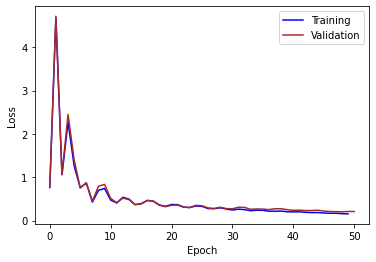

In [11]:
# Training and Validation Error plot

plt.plot(sentnet.get_error_trace()[0], color = 'b', label = 'Training')
plt.plot(sentnet.get_error_trace()[1], color = 'brown', label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

## References:

1. Sazzed, Salim (2021), “Bangla ( Bengali ) sentiment analysis classification benchmark dataset corpus”, Mendeley Data, V4, doi: 10.17632/p6zc7krs37.4
2. [Attention from scratch](https://medium.com/the-dl/transformers-from-scratch-in-pytorch-8777e346ca51)